# RNN For Name Classification 😀

### downloading the data and necessary functions

In [1]:
import requests
import zipfile
import io
import os

def download_and_extract_zip(url, extract_to):
    try:
        # Send a GET request to the URL
        print(f"Downloading ZIP file from {url}...")
        response = requests.get(url)

        # Raise an exception for bad status codes
        response.raise_for_status()

        # Create a ZipFile object from the downloaded content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Create the extraction directory if it doesn't exist
            os.makedirs(extract_to, exist_ok=True)

            # Extract all the contents into the specified directory
            print(f"Extracting contents to {extract_to}...")
            zip_ref.extractall(extract_to)

        print("Download and extraction completed successfully.")

        # List the extracted files
        print("\nExtracted files:")
        for root, dirs, files in os.walk(extract_to):
            for file in files:
                print(os.path.join(root, file))

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the ZIP file: {e}")
    except zipfile.BadZipFile:
        print("The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
url = "https://download.pytorch.org/tutorial/data.zip"  # Replace with your actual ZIP file URL
extract_to = "data"  # Replace with your desired extraction directory

download_and_extract_zip(url, extract_to)

Extracting contents to data...
Download and extraction completed successfully.

Extracted files:
data/data/eng-fra.txt
data/data/names/Spanish.txt
data/data/names/English.txt
data/data/names/Polish.txt
data/data/names/Irish.txt
data/data/names/Chinese.txt
data/data/names/Italian.txt
data/data/names/German.txt
data/data/names/French.txt
data/data/names/Czech.txt
data/data/names/Portuguese.txt
data/data/names/Vietnamese.txt
data/data/names/Scottish.txt
data/data/names/Greek.txt
data/data/names/Arabic.txt
data/data/names/Japanese.txt
data/data/names/Dutch.txt
data/data/names/Russian.txt
data/data/names/Korean.txt


In [9]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

In [6]:
all_letters = string.ascii_letters + ".,;"
all_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'

In [7]:
n_letters = len(all_letters)
n_letters

55

In [43]:
# def unicode_to_ascii(s):
#     return ''.join(
#         # Normalize the string 's' using NFD normalization
#         normalized_string = unicodedata.normalize('NFD', s)

#         # Initialize an empty list to hold the filtered characters
#         filtered_characters = []

#         # Iterate over each character in the normalized string
#         for c in normalized_string:
#             # Check if the character is not a non-spacing mark and is in ALL_LETTERS
#             if unicodedata.category(c) != 'Mn' and c in ALL_LETTERS:
#                 # Append the character to the filtered list
#                 filtered_characters.append(c)

#         # The result is the list of filtered characters
#         result = filtered_characters
#     )
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


In [37]:
import os
import glob
import io

def load_data():
    # Build the category_lines dictionary, a list of names per language
    # basically all_categories the name in a particular language/category into a list
    # and category lines is a dictionary like "category x:names in x"
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    # Adjust the path based on your structure: data-rnn/data/names
    for filename in find_files('data-rnn/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

In [38]:
def letter_to_index(letter):
    return all_letters.find(letter)

In [39]:
def line_to_tensor(line):
  """
  intialises a 3d array in which
  1st dim : the no of letters in the input
  2nd dim : its always 1(normally tells about the match)
  3rd dim : no of total letters
  """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor
line_to_tensor('chirag')

IndentationError: unexpected indent (<ipython-input-39-4f30c20bcf34>, line 8)

In [40]:
def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

### coding RNN


In [41]:


import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**Architecture Using For This RNN**-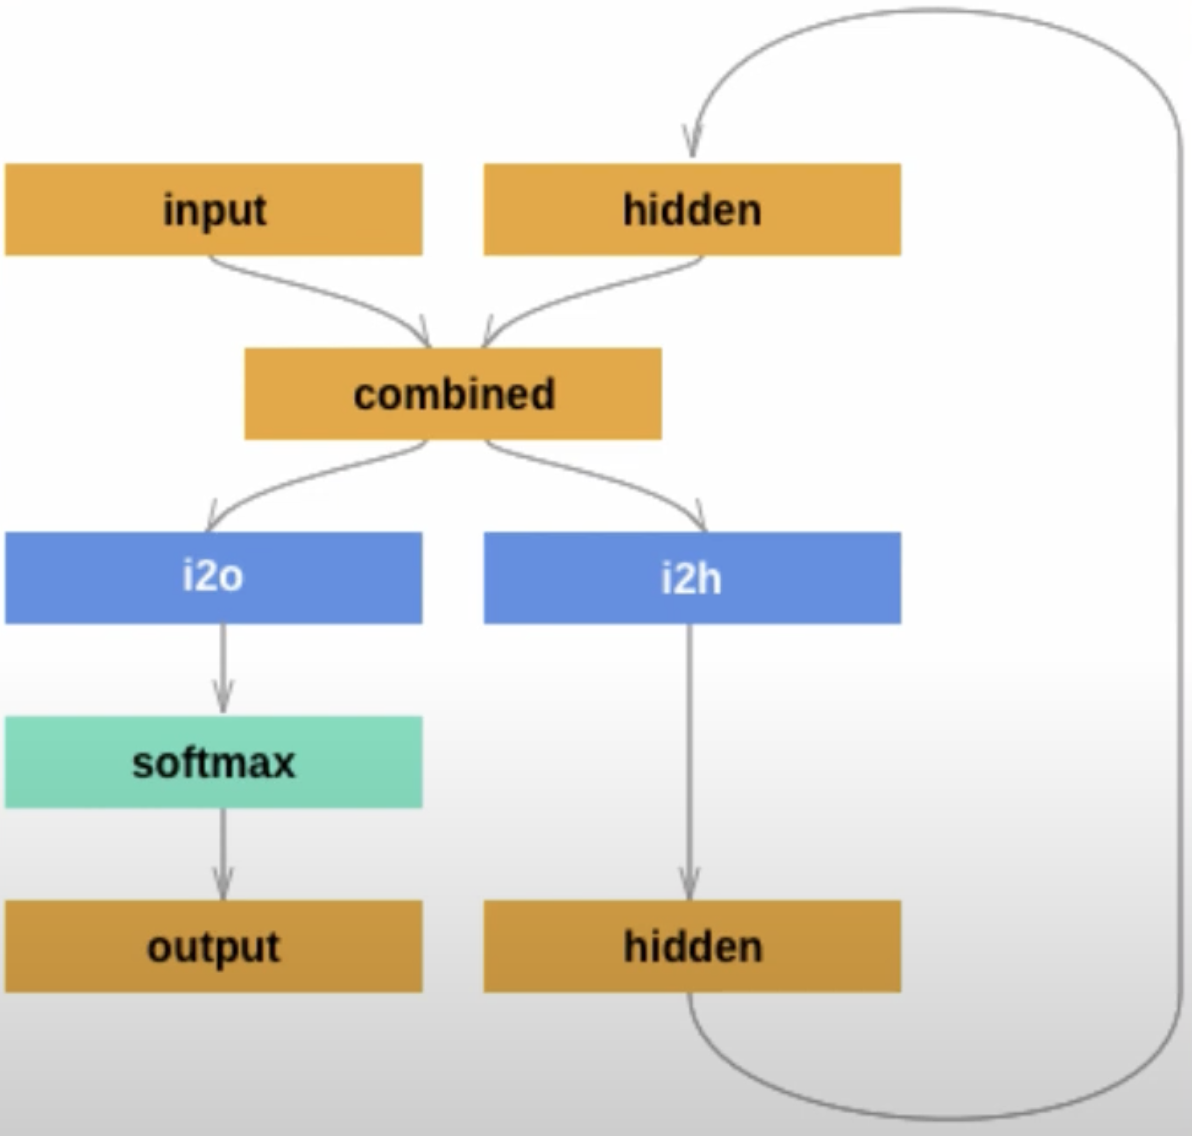

In [100]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN,self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size, input_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):

    combined = torch.cat((input_tensor, hidden_tensor), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  #initialising the hidden matrix with 0
  def init_hidden(self):
    return torch.zeros(1,self.hidden_size)

In [101]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_categories

18

In [102]:
rnn = RNN(n_letters, hidden_size=128, output_size=n_categories)
rnn

RNN(
  (i2h): Linear(in_features=183, out_features=128, bias=True)
  (i2o): Linear(in_features=183, out_features=55, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [103]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]



In [104]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(),0.005)

In [105]:
# training loop
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [106]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000

In [108]:
epochs = 100000
for epoch in range(epochs):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (epoch+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (epoch+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{epoch+1} {(epoch+1)/epochs*100} {loss:.2f} {line} / {guess} {correct}")


5000 5.0 1.55 Han / Chinese WRONG (Korean)
10000 10.0 2.10 Nishimura / Spanish WRONG (Japanese)
15000 15.0 1.92 Kelly / Scottish CORRECT
20000 20.0 1.08 Song / Chinese WRONG (Korean)
25000 25.0 1.57 Bonnet / French CORRECT
30000 30.0 0.66 Kaczka / Polish CORRECT
35000 35.0 1.09 Weeber / German CORRECT
40000 40.0 1.94 Duncan / Irish WRONG (Scottish)
45000 45.0 0.54 Sowka / Polish CORRECT
50000 50.0 1.48 Chajengin / Irish WRONG (Russian)
55000 55.00000000000001 0.28 Seok / Korean CORRECT
60000 60.0 0.61 Picha / Czech CORRECT
65000 65.0 2.45 Schultheiss / Greek WRONG (German)
70000 70.0 1.38 Ha / Korean WRONG (Vietnamese)
75000 75.0 0.44 Kachalovsky / Russian CORRECT
80000 80.0 1.01 Meeuwissen / Dutch CORRECT
85000 85.0 0.37 Ly / Vietnamese CORRECT
90000 90.0 0.48 Antoun / Arabic CORRECT
95000 95.0 0.53 Donoghue / Irish CORRECT
100000 100.0 1.08 Wang / Chinese WRONG (Korean)


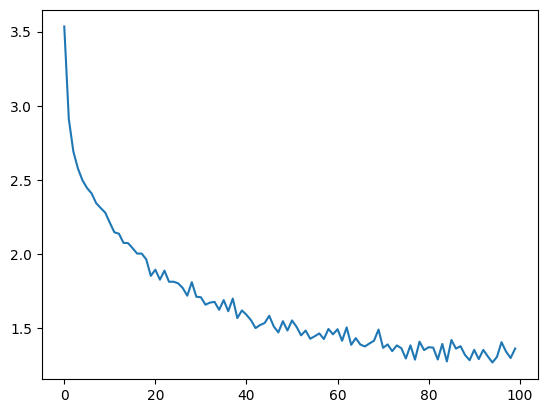

In [109]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [110]:

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

In [111]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)

Input:wang

> wang
Korean
Input:Attia

> Attia
Arabic
Input:Abel

> Abel
Dutch
Input:Adam

> Adam
Arabic
Input:Baudin

> Baudin
Irish
Input:quit
